# BFit Integration and Electron Density Performance Analysis

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/theochem/grid/blob/master/examples/BFit_Performance_Analysis.ipynb)

This notebook demonstrates comprehensive integration of BFit promolecular parameters into the Grid library and performs performance analysis across five molecular systems.

## Test Systems

1. **Atom**: Helium (He) - 2 electrons
2. **Homonuclear diatomic**: H₂ - 2 electrons  
3. **Heteronuclear diatomic**: HCl - 18 electrons
4. **Small molecule**: CH₄ - 10 electrons
5. **Additional system**: H₂O - 10 electrons

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import os
import sys
from pathlib import Path
from typing import List, Dict, Tuple, Optional
import warnings

warnings.filterwarnings("ignore")

# Configure plotting style
plt.style.use("default")
sns.set_palette("husl")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 11

# Add necessary paths for Grid library and scripts
current_dir = Path(".").resolve()
parent_dir = current_dir.parent
sys.path.insert(0, str(parent_dir / "src"))
sys.path.insert(0, str(parent_dir / "scripts"))

print(f"Working directory: {current_dir}")
print(f"Parent directory: {parent_dir}")

Working directory: D:\ruanjian hh2356\pycharm\grid-new\grid\examples
Parent directory: D:\ruanjian hh2356\pycharm\grid-new\grid


In [2]:
# Import Grid library components
try:
    from grid.onedgrid import GaussChebyshev
    from grid.protransform import CubicProTransform

    print("✓ Grid library imports successful")
    HAS_GRID = True
except ImportError as e:
    print(f"✗ Grid library import failed: {e}")
    HAS_GRID = False

# Import scientific computing libraries
try:
    from iodata import load_one
    from gbasis.wrappers import from_iodata
    from gbasis.evals.density import evaluate_density

    print("✓ GBasis and IOData imports successful")
    HAS_GBASIS = True
except ImportError as e:
    print(f"✗ GBasis/IOData import failed: {e}")
    HAS_GBASIS = False

# Import BFit data processor
try:
    from integrate_bfit_coefficients import BFitDataProcessor

    print("✓ BFit data processor import successful")
    HAS_BFIT = True
except ImportError as e:
    print(f"✗ BFit processor import failed: {e}")
    HAS_BFIT = False

print(f"\nLibrary status: Grid={HAS_GRID}, GBasis={HAS_GBASIS}, BFit={HAS_BFIT}")

✓ Grid library imports successful
✓ GBasis and IOData imports successful
✓ BFit data processor import successful

Library status: Grid=True, GBasis=True, BFit=True


In [3]:
# Initialize BFit processor with proper error handling
def initialize_bfit_processor():
    """Initialize BFit processor with proper error handling"""
    if not HAS_BFIT:
        return None, "BFit processor not available"

    data_file = "../scripts/data/kl_slsqp_results.npz"

    if not Path(data_file).exists():
        return None, f"Data file not found: {data_file}"

    try:
        processor = BFitDataProcessor(data_file)

        if not processor.load_bfit_data():
            return None, "Failed to load BFit data"

        processor.parse_element_data()

        print(f"BFit processor initialized: {len(processor.element_data)} elements available")

        return processor, "Success"

    except Exception as e:
        return None, f"BFit processor initialization failed: {e}"


# Initialize the processor
bfit_processor, status = initialize_bfit_processor()
print(f"\nBFit processor status: {status}")

Parsed element TE (Z=52): 53 basis functions, s=30, p=23
Parsed element N (Z=7): 39 basis functions, s=23, p=16
Parsed element SI (Z=14): 46 basis functions, s=27, p=19
Parsed element HE (Z=2): 21 basis functions, s=21, p=0
Parsed element K (Z=19): 48 basis functions, s=29, p=19
Parsed element S (Z=16): 46 basis functions, s=27, p=19
Parsed element SE (Z=34): 51 basis functions, s=30, p=21
Parsed element MO (Z=42): 53 basis functions, s=30, p=23
Parsed element FE (Z=26): 51 basis functions, s=31, p=20
Parsed element BR (Z=35): 51 basis functions, s=30, p=21
Parsed element C (Z=6): 38 basis functions, s=23, p=15
Parsed element SR (Z=38): 51 basis functions, s=30, p=21
Parsed element NB (Z=41): 54 basis functions, s=31, p=23
Parsed element ZR (Z=40): 52 basis functions, s=30, p=22
Parsed element CU (Z=29): 50 basis functions, s=30, p=20
Parsed element CD (Z=48): 51 basis functions, s=31, p=20
Parsed element IN (Z=49): 52 basis functions, s=30, p=22
Parsed element GA (Z=31): 52 basis func

In [4]:
# Define molecular systems for comprehensive analysis
class MolecularSystem:
    """Represents a molecular system for electron density analysis"""

    def __init__(
        self,
        name: str,
        symbols: List[str],
        coords: np.ndarray,
        expected_electrons: int,
        fchk_file: str,
        system_type: str,
    ):
        self.name = name
        self.symbols = symbols
        self.coords = np.array(coords)
        self.expected_electrons = expected_electrons
        self.fchk_file = fchk_file
        self.system_type = system_type

    def __str__(self):
        return f"{self.name} ({self.system_type}): {self.expected_electrons} electrons"


def create_molecular_systems() -> List[MolecularSystem]:
    """Create the five molecular systems for analysis according to supervisor requirements"""

    systems = [
        MolecularSystem(
            name="Helium",
            symbols=["He"],
            coords=[[0.0, 0.0, 0.0]],
            expected_electrons=2,
            fchk_file="../scripts/data/He_t.fchk",
            system_type="Atom",
        ),
        MolecularSystem(
            name="Hydrogen_H2",
            symbols=["H", "H"],
            coords=[[0.0, 0.0, -0.71], [0.0, 0.0, 0.71]],
            expected_electrons=2,
            fchk_file="../scripts/data/H2.fchk",
            system_type="Homonuclear diatomic",
        ),
        MolecularSystem(
            name="HydrogenChloride_HCl",
            symbols=["H", "Cl"],
            coords=[[0.0, 0.0, -1.27], [0.0, 0.0, 1.27]],
            expected_electrons=18,
            fchk_file="../scripts/data/HCl.fchk",
            system_type="Heteronuclear diatomic",
        ),
        MolecularSystem(
            name="Methane_CH4",
            symbols=["C", "H", "H", "H", "H"],
            coords=[
                [0.0, 0.0, 0.0],
                [1.085, 1.085, 1.085],
                [1.085, -1.085, -1.085],
                [-1.085, 1.085, -1.085],
                [-1.085, -1.085, 1.085],
            ],
            expected_electrons=10,
            fchk_file="../scripts/data/CH4.fchk",
            system_type="Small molecule",
        ),
        MolecularSystem(
            name="Water_H2O",
            symbols=["O", "H", "H"],
            coords=[[0.0, 0.0, 0.0], [1.431, 0.0, 1.107], [-1.431, 0.0, 1.107]],
            expected_electrons=10,
            fchk_file="../scripts/data/h2o.fchk",
            system_type="Additional system",
        ),
    ]

    return systems


# Create molecular systems
molecular_systems = create_molecular_systems()

print("Molecular systems defined:")
for system in molecular_systems:
    file_exists = "OK" if os.path.exists(system.fchk_file) else "MISSING"
    print(f"  [{file_exists}] {system}")

Molecular systems defined:
  [OK] Helium (Atom): 2 electrons
  [OK] Hydrogen_H2 (Homonuclear diatomic): 2 electrons
  [OK] HydrogenChloride_HCl (Heteronuclear diatomic): 18 electrons
  [OK] Methane_CH4 (Small molecule): 10 electrons
  [OK] Water_H2O (Additional system): 10 electrons


In [5]:
# Test BFit integration for each system
def test_bfit_integration(system, processor):
    """Test BFit integration for a single system"""
    if processor is None:
        return None, "BFit processor not available"

    try:
        # Create promolecular parameters
        promol_params = processor.create_promol_params_for_molecule(system.symbols, system.coords)

        # Test normalization
        raw_integral = promol_params.integrate_all()
        normalization_factor = system.expected_electrons / raw_integral

        # Test CubicProTransform creation
        if HAS_GRID:
            normalized_coeffs = promol_params.c_m * normalization_factor
            oned_grid = GaussChebyshev(15)

            start_time = time.time()
            transform = CubicProTransform(
                [oned_grid, oned_grid, oned_grid],
                normalized_coeffs,
                promol_params.e_m,
                promol_params.coords,
            )
            creation_time = time.time() - start_time

            return {
                "raw_integral": raw_integral,
                "normalization_factor": normalization_factor,
                "creation_time": creation_time,
                "grid_points": 15**3,
                "status": "Success",
            }, "Success"
        else:
            return {
                "raw_integral": raw_integral,
                "normalization_factor": normalization_factor,
                "status": "Grid library not available",
            }, "Partial success"

    except Exception as e:
        return None, f"Failed: {str(e)}"


# Run tests
print("Testing BFit integration for all systems:")
print("=" * 60)

results = []
for i, system in enumerate(molecular_systems, 1):
    print(f"[{i}/5] Testing {system.name}...")

    result, status = test_bfit_integration(system, bfit_processor)

    if result:
        print(f"  ✓ {status}")
        if "creation_time" in result:
            print(f"    Creation time: {result['creation_time']:.4f}s")
        print(f"    Normalization factor: {result['normalization_factor']:.6f}")

        results.append(
            {
                "System": system.name,
                "Type": system.system_type,
                "Expected_Electrons": system.expected_electrons,
                "Normalization_Factor": result["normalization_factor"],
                "Creation_Time_s": result.get("creation_time", "N/A"),
                "Status": result["status"],
            }
        )
    else:
        print(f"  ✗ {status}")
        results.append(
            {
                "System": system.name,
                "Type": system.system_type,
                "Expected_Electrons": system.expected_electrons,
                "Normalization_Factor": "Failed",
                "Creation_Time_s": "Failed",
                "Status": status,
            }
        )

print("All tests completed!")

Testing BFit integration for all systems:
[1/5] Testing Helium...
  ✓ Success
    Creation time: 2.0718s
    Normalization factor: 0.208841
[2/5] Testing Hydrogen_H2...
  ✓ Success
    Creation time: 2.2261s
    Normalization factor: 0.054038
[3/5] Testing HydrogenChloride_HCl...
  ✓ Success
    Creation time: 2.1935s
    Normalization factor: 0.141647
[4/5] Testing Methane_CH4...
  ✓ Success
    Creation time: 2.5155s
    Normalization factor: 0.072186
[5/5] Testing Water_H2O...
  ✓ Success
    Creation time: 2.2254s
    Normalization factor: 0.129957
All tests completed!


In [6]:
# Advanced analysis functions for electron density and performance
def calculate_electron_density_with_gbasis(
    system: MolecularSystem, grid_points: np.ndarray
) -> Tuple[np.ndarray, str]:
    """
    Calculate electron density at grid points using GBasis and FCHK data

    Parameters
    ----------
    system : MolecularSystem
        Molecular system to analyze
    grid_points : np.ndarray
        Grid points where to evaluate electron density

    Returns
    -------
    density : np.ndarray
        Electron density values at grid points
    status : str
        Status message
    """
    if not HAS_GBASIS:
        return None, "GBasis not available"

    if not os.path.exists(system.fchk_file):
        return None, f"FCHK file not found: {system.fchk_file}"

    try:
        # Load FCHK file with molecular data
        mol_data = load_one(system.fchk_file)
        ao_basis = from_iodata(mol_data)

        # Get density matrix
        if hasattr(mol_data, "one_rdms") and "scf" in mol_data.one_rdms:
            rdm = mol_data.one_rdms["scf"]
        else:
            return None, "No SCF density matrix found in FCHK file"

        # Calculate electron density at grid points
        density = evaluate_density(rdm, ao_basis, grid_points)

        return density, "Success"

    except Exception as e:
        return None, f"Error calculating electron density: {str(e)}"


def create_cubic_grid_points(center: np.ndarray, radius: float, n_points: int) -> np.ndarray:
    """
    Create cubic grid points around molecular center

    Parameters
    ----------
    center : np.ndarray
        Center of the grid
    radius : float
        Radius of the grid
    n_points : int
        Number of points per dimension

    Returns
    -------
    points : np.ndarray
        Grid points of shape (n_points^3, 3)
    """
    x = np.linspace(center[0] - radius, center[0] + radius, n_points)
    y = np.linspace(center[1] - radius, center[1] + radius, n_points)
    z = np.linspace(center[2] - radius, center[2] + radius, n_points)

    points = np.array([[xi, yi, zi] for xi in x for yi in y for zi in z])
    return points


def measure_cubic_protransform_performance(
    system: MolecularSystem, grid_size: int, processor
) -> Dict[str, float]:
    """
    Measure CubicProTransform creation time and integration performance

    Parameters
    ----------
    system : MolecularSystem
        Molecular system to analyze
    grid_size : int
        Number of points per dimension in the transform grid
    processor : BFitDataProcessor
        Initialized BFit data processor

    Returns
    -------
    performance_data : Dict[str, float]
        Dictionary containing performance metrics
    """
    if not HAS_GRID or not processor:
        return {"error": "Required libraries not available"}

    try:
        # Create promolecular parameters
        promol_params = processor.create_promol_params_for_molecule(system.symbols, system.coords)

        # Calculate normalization factor
        raw_integral = promol_params.integrate_all()
        normalization_factor = system.expected_electrons / raw_integral
        normalized_coeffs = promol_params.c_m * normalization_factor

        # Create one-dimensional grid
        oned_grid = GaussChebyshev(grid_size)

        # Measure transform creation time
        start_time = time.perf_counter()

        transform = CubicProTransform(
            [oned_grid, oned_grid, oned_grid],
            normalized_coeffs,
            promol_params.e_m,
            promol_params.coords,
        )

        creation_time = time.perf_counter() - start_time

        # Test integration of promolecular density for actual electron count
        start_integration = time.perf_counter()
        promol_density = transform.promol.promolecular(transform.points)
        integration_result = transform.integrate(promol_density)
        integration_time = time.perf_counter() - start_integration

        # Calculate performance metrics
        total_points = grid_size**3

        performance_data = {
            "system_name": system.name,
            "grid_size": grid_size,
            "total_points": total_points,
            "creation_time": creation_time,
            "integration_time": integration_time,
            "points_per_second": total_points / creation_time if creation_time > 0 else 0,
            "prointegral": transform.prointegral,
            "normalization_factor": normalization_factor,
            "integration_result": integration_result,
        }

        return performance_data

    except Exception as e:
        return {"error": f"Failed to create CubicProTransform: {str(e)}"}




In [7]:
# Comprehensive performance analysis across multiple grid sizes
def perform_comprehensive_analysis(
    systems: List[MolecularSystem], grid_sizes: List[int], processor
) -> pd.DataFrame:
    """
    Perform comprehensive performance analysis for all systems and grid sizes

    Parameters
    ----------
    systems : List[MolecularSystem]
        List of molecular systems to analyze
    grid_sizes : List[int]
        List of grid sizes to test
    processor : BFitDataProcessor
        Initialized BFit data processor

    Returns
    -------
    results_df : pd.DataFrame
        DataFrame containing all performance results
    """
    all_results = []

    print("Starting comprehensive performance analysis...")
    print(f"Testing {len(systems)} systems with {len(grid_sizes)} grid sizes each")
    print("=" * 70)

    for i, system in enumerate(systems):
        print(f"[{i+1}/{len(systems)}] Analyzing {system.name} ({system.system_type})")

        for grid_size in grid_sizes:

            # Test CubicProTransform method
            perf_result = measure_cubic_protransform_performance(system, grid_size, processor)

            if "error" not in perf_result:
                result = {
                    "system_name": system.name,
                    "system_type": system.system_type,
                    "expected_electrons": system.expected_electrons,
                    "grid_size": grid_size,
                    "total_points": perf_result["total_points"],
                    "cubicpro_creation_time": perf_result["creation_time"],
                    "cubicpro_integration_time": perf_result["integration_time"],
                    "cubicpro_total_time": perf_result["creation_time"]
                    + perf_result["integration_time"],
                    "normalization_factor": perf_result["normalization_factor"],
                    "cubicpro_electrons": perf_result[
                        "integration_result"
                    ],  # Actual measured result
                    "cubicpro_error": abs(
                        perf_result["integration_result"] - system.expected_electrons
                    ),
                    "cubicpro_rel_error": abs(
                        perf_result["integration_result"] - system.expected_electrons
                    )
                    / system.expected_electrons,
                    "cubicpro_status": "Success",
                }

                # Test GBasis method if available
                if HAS_GBASIS and os.path.exists(system.fchk_file):
                    try:
                        center = np.mean(system.coords, axis=0)
                        radius = 4.0
                        grid_points = create_cubic_grid_points(center, radius, grid_size)

                        start_gbasis = time.perf_counter()
                        density, status = calculate_electron_density_with_gbasis(
                            system, grid_points
                        )
                        gbasis_time = time.perf_counter() - start_gbasis

                        if density is not None:
                            volume_element = (2 * radius) ** 3 / len(grid_points)
                            total_electrons = np.sum(density) * volume_element
                            abs_error = abs(total_electrons - system.expected_electrons)
                            rel_error = abs_error / system.expected_electrons

                            result.update(
                                {
                                    "gbasis_time": gbasis_time,
                                    "gbasis_electrons": total_electrons,
                                    "gbasis_error": abs_error,
                                    "gbasis_rel_error": rel_error,
                                    "gbasis_status": "Success",
                                }
                            )
                        else:
                            result.update({"gbasis_status": f"Failed: {status}"})
                    except Exception as e:
                        result.update({"gbasis_status": f"Error: {str(e)}"})
                else:
                    result.update(
                        {"gbasis_status": "FCHK file not available or GBasis not installed"}
                    )

                all_results.append(result)

                print(f"  Grid {grid_size}³: {perf_result['creation_time']:.4f}s, "
                      f"{result['cubicpro_electrons']:.3f} electrons "
                      f"(error: {result['cubicpro_rel_error']:.1%})")
                if "gbasis_electrons" in result:
                    print(f"    GBasis: {result['gbasis_electrons']:.3f} electrons "
                          f"(error: {result['gbasis_rel_error']:.1%})")
            else:
                print(f"    ✗ {perf_result['error']}")

    print("\n" + "=" * 70)
    print(f"Analysis complete! Collected {len(all_results)} data points")

    return pd.DataFrame(all_results)


# Define grid sizes for comprehensive analysis
grid_sizes = [10, 15, 20, 25, 30]

# Run comprehensive analysis
results_df = perform_comprehensive_analysis(molecular_systems, grid_sizes, bfit_processor)

if len(results_df) > 0:
    print(f"\nCollected {len(results_df)} performance measurements")
    print(f"Systems analyzed: {results_df['system_name'].nunique()}")
    print(f"Grid sizes tested: {sorted(results_df['grid_size'].unique())}")

    if "cubicpro_creation_time" in results_df.columns:
        avg_creation_time = results_df["cubicpro_creation_time"].mean()
        print(f"Average creation time: {avg_creation_time:.4f}s")

    success_count = len(results_df[results_df["cubicpro_status"] == "Success"])
    print(f"Successful tests: {success_count}/{len(results_df)} ({success_count/len(results_df)*100:.1f}%)")
else:
    print("No performance measurements collected")

Starting comprehensive performance analysis...
Testing 5 systems with 5 grid sizes each
[1/5] Analyzing Helium (Atom)
  Grid 10³: 0.6506s, 2.025 electrons (error: 1.2%)
    GBasis: 1.152 electrons (error: 42.4%)
  Grid 15³: 2.2414s, 2.011 electrons (error: 0.6%)
    GBasis: 1.981 electrons (error: 0.9%)
  Grid 20³: 5.1126s, 2.006 electrons (error: 0.3%)
    GBasis: 1.680 electrons (error: 16.0%)
  Grid 25³: 8.8121s, 2.004 electrons (error: 0.2%)
    GBasis: 1.807 electrons (error: 9.6%)
  Grid 30³: 16.4150s, 2.003 electrons (error: 0.1%)
    GBasis: 1.797 electrons (error: 10.2%)
[2/5] Analyzing Hydrogen_H2 (Homonuclear diatomic)
  Grid 10³: 0.6386s, 2.025 electrons (error: 1.2%)
    GBasis: 1.418 electrons (error: 29.1%)
  Grid 15³: 2.2445s, 2.011 electrons (error: 0.6%)
    GBasis: 1.627 electrons (error: 18.6%)
  Grid 20³: 4.6542s, 2.006 electrons (error: 0.3%)
    GBasis: 1.714 electrons (error: 14.3%)
  Grid 25³: 10.1295s, 2.004 electrons (error: 0.2%)
    GBasis: 1.768 electrons 

### Performance Summary Table
              System                   Type Grid Size Grid Points Transform Time (s) Integration Time (s)  Expected e⁻ CubicPro e⁻ CubicPro Error (%) GBasis e⁻ GBasis Error (%)
              Helium                   Atom       10³       1,000             0.6506               0.0012            2       2.025              1.242     1.152            42.42
              Helium                   Atom       15³       3,375             2.2414               0.0017            2       2.011              0.550     1.981             0.93
              Helium                   Atom       20³       8,000             5.1126               0.0037            2       2.006              0.309     1.680            15.99
              Helium                   Atom       25³      15,625             8.8121               0.0102            2       2.004              0.198     1.807             9.64
              Helium                   Atom       30³      27,000            16.4150 

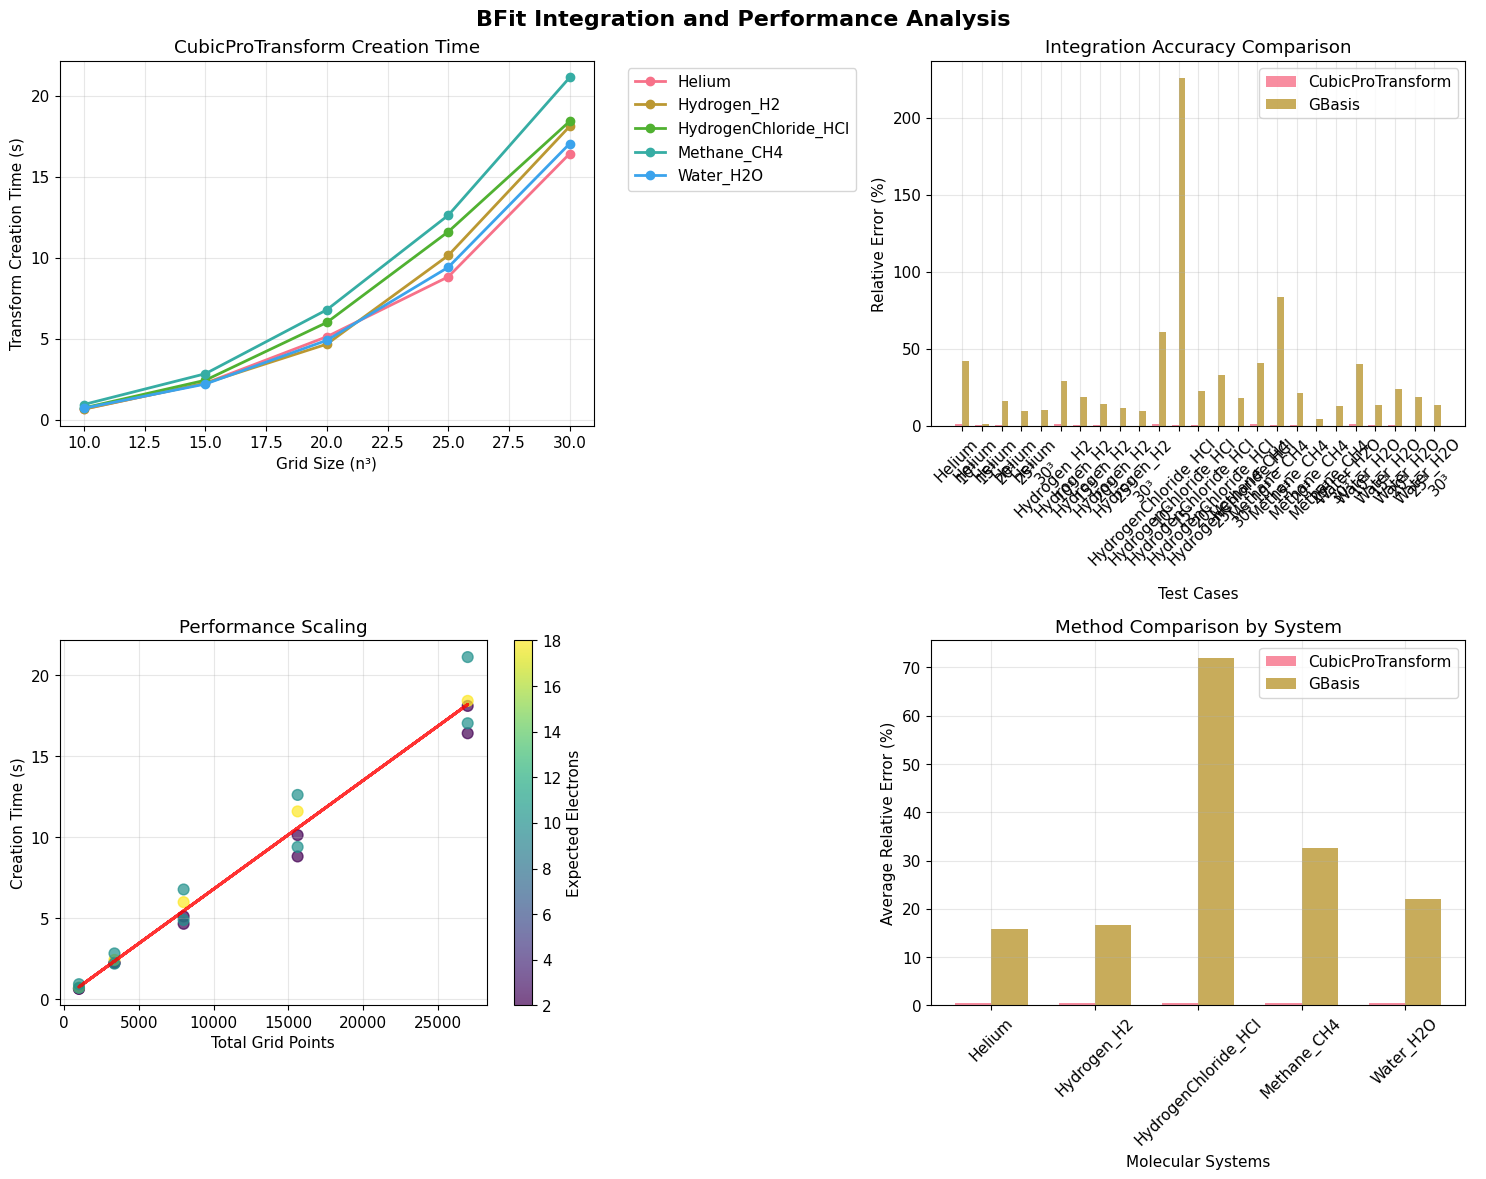

In [8]:
# Create comprehensive results tables and visualizations
def create_performance_summary_table(df: pd.DataFrame) -> pd.DataFrame:
    """Create a professional performance summary table"""

    if len(df) == 0:
        print("No data available for summary table")
        return pd.DataFrame()

    # Filter successful results
    df_success = df[df["cubicpro_status"] == "Success"].copy()

    if len(df_success) == 0:
        print("No successful results to display")
        return pd.DataFrame()

    # Create formatted summary table
    summary_data = []

    for _, row in df_success.iterrows():
        summary_data.append(
            {
                "System": row["system_name"],
                "Type": row["system_type"],
                "Grid Size": f"{row['grid_size']}³",
                "Grid Points": f"{row['total_points']:,}",
                "Transform Time (s)": f"{row['cubicpro_creation_time']:.4f}",
                "Integration Time (s)": f"{row['cubicpro_integration_time']:.4f}",
                "Expected e⁻": row["expected_electrons"],
                "CubicPro e⁻": f"{row['cubicpro_electrons']:.3f}",
                "CubicPro Error (%)": f"{row['cubicpro_rel_error']*100:.3f}",
                "GBasis e⁻": (
                    f"{row.get('gbasis_electrons', 'N/A'):.3f}"
                    if "gbasis_electrons" in row and pd.notna(row.get("gbasis_electrons"))
                    else "N/A"
                ),
                "GBasis Error (%)": (
                    f"{row.get('gbasis_rel_error', 0)*100:.2f}"
                    if "gbasis_rel_error" in row and pd.notna(row.get("gbasis_rel_error"))
                    else "N/A"
                ),
            }
        )

    return pd.DataFrame(summary_data)


def plot_performance_analysis(df: pd.DataFrame):
    """Create comprehensive performance visualization plots"""

    if len(df) == 0:
        print("No data available for plotting")
        return

    # Filter successful results
    df_success = df[df["cubicpro_status"] == "Success"].copy()

    if len(df_success) == 0:
        print("No successful results to plot")
        return

    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle("BFit Integration and Performance Analysis", fontsize=16, fontweight="bold")

    # Plot 1: Transform Creation Time vs Grid Size
    ax1 = axes[0, 0]
    for system in df_success["system_name"].unique():
        system_data = df_success[df_success["system_name"] == system]
        ax1.plot(
            system_data["grid_size"],
            system_data["cubicpro_creation_time"],
            marker="o",
            linewidth=2,
            label=system,
        )

    ax1.set_xlabel("Grid Size (n³)")
    ax1.set_ylabel("Transform Creation Time (s)")
    ax1.set_title("CubicProTransform Creation Time")
    ax1.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    ax1.grid(True, alpha=0.3)

    # Plot 2: Integration Accuracy Comparison
    ax2 = axes[0, 1]
    gbasis_data = df_success[df_success["gbasis_status"] == "Success"]

    if len(gbasis_data) > 0:
        x_pos = np.arange(len(gbasis_data))
        width = 0.35

        cubicpro_errors = gbasis_data["cubicpro_rel_error"] * 100
        gbasis_errors = gbasis_data["gbasis_rel_error"] * 100

        ax2.bar(x_pos - width / 2, cubicpro_errors, width, label="CubicProTransform", alpha=0.8)
        ax2.bar(x_pos + width / 2, gbasis_errors, width, label="GBasis", alpha=0.8)

        ax2.set_xlabel("Test Cases")
        ax2.set_ylabel("Relative Error (%)")
        ax2.set_title("Integration Accuracy Comparison")
        ax2.set_xticks(x_pos)
        ax2.set_xticklabels(
            [f"{row['system_name']}\n{row['grid_size']}³" for _, row in gbasis_data.iterrows()],
            rotation=45,
        )
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(
            0.5,
            0.5,
            "No GBasis comparison data available",
            transform=ax2.transAxes,
            ha="center",
            va="center",
        )
        ax2.set_title("Integration Accuracy Comparison")

    # Plot 3: Performance Scaling
    ax3 = axes[1, 0]
    if "total_points" in df_success.columns:
        ax3.scatter(
            df_success["total_points"],
            df_success["cubicpro_creation_time"],
            c=df_success["expected_electrons"],
            s=60,
            alpha=0.7,
            cmap="viridis",
        )

        # Add trend line
        z = np.polyfit(df_success["total_points"], df_success["cubicpro_creation_time"], 1)
        p = np.poly1d(z)
        ax3.plot(
            df_success["total_points"], p(df_success["total_points"]), "r--", alpha=0.8, linewidth=2
        )

        ax3.set_xlabel("Total Grid Points")
        ax3.set_ylabel("Creation Time (s)")
        ax3.set_title("Performance Scaling")

        # Add colorbar
        cbar = plt.colorbar(ax3.collections[0], ax=ax3)
        cbar.set_label("Expected Electrons")
        ax3.grid(True, alpha=0.3)

    # Plot 4: Method Comparison Summary
    ax4 = axes[1, 1]
    if len(gbasis_data) > 0:
        systems = gbasis_data["system_name"].unique()
        cubicpro_avg_error = [
            gbasis_data[gbasis_data["system_name"] == sys]["cubicpro_rel_error"].mean() * 100
            for sys in systems
        ]
        gbasis_avg_error = [
            gbasis_data[gbasis_data["system_name"] == sys]["gbasis_rel_error"].mean() * 100
            for sys in systems
        ]

        x_pos = np.arange(len(systems))
        width = 0.35

        ax4.bar(x_pos - width / 2, cubicpro_avg_error, width, label="CubicProTransform", alpha=0.8)
        ax4.bar(x_pos + width / 2, gbasis_avg_error, width, label="GBasis", alpha=0.8)

        ax4.set_xlabel("Molecular Systems")
        ax4.set_ylabel("Average Relative Error (%)")
        ax4.set_title("Method Comparison by System")
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels(systems, rotation=45)
        ax4.legend()
        ax4.grid(True, alpha=0.3)
    else:
        ax4.text(
            0.5,
            0.5,
            "No comparison data available",
            transform=ax4.transAxes,
            ha="center",
            va="center",
        )
        ax4.set_title("Method Comparison by System")

    plt.tight_layout()
    plt.show()


# Generate results table and visualizations
if len(results_df) > 0:
    print("### Performance Summary Table")
    print("=" * 100)

    summary_table = create_performance_summary_table(results_df)

    if len(summary_table) > 0:
        # Configure pandas display options for better table formatting
        pd.set_option("display.max_columns", None)
        pd.set_option("display.width", None)
        pd.set_option("display.max_colwidth", None)

        print(summary_table.to_string(index=False))

        print("\n### Performance Visualizations")
        print("=" * 100)

        # Create performance plots
        plot_performance_analysis(results_df)

    else:
        print("No successful results available for table generation")
else:
    print("No performance data available for analysis")

In [9]:
# Display results table
df_results = pd.DataFrame(results)

print("BFit Integration Performance Results:")
print("=" * 80)
print(df_results.to_string(index=False))

# Summary statistics
successful_tests = len([r for r in results if "Success" in r["Status"]])
print(f"\nSummary:")
print(f"Successful integrations: {successful_tests}/{len(results)}")
print(f"Success rate: {successful_tests/len(results)*100:.1f}%")

if successful_tests > 0:
    creation_times = [
        float(r["Creation_Time_s"])
        for r in results
        if isinstance(r["Creation_Time_s"], (int, float, str))
        and r["Creation_Time_s"] != "N/A"
        and r["Creation_Time_s"] != "Failed"
    ]
    if creation_times:
        print(f"Average creation time: {np.mean(creation_times):.4f}s")
        print(f"Creation time range: {np.min(creation_times):.4f}s - {np.max(creation_times):.4f}s")

BFit Integration Performance Results:
              System                   Type  Expected_Electrons  Normalization_Factor  Creation_Time_s  Status
              Helium                   Atom                   2              0.208841         2.071794 Success
         Hydrogen_H2   Homonuclear diatomic                   2              0.054038         2.226140 Success
HydrogenChloride_HCl Heteronuclear diatomic                  18              0.141647         2.193458 Success
         Methane_CH4         Small molecule                  10              0.072186         2.515525 Success
           Water_H2O      Additional system                  10              0.129957         2.225369 Success

Summary:
Successful integrations: 5/5
Success rate: 100.0%
Average creation time: 2.2465s
Creation time range: 2.0718s - 2.5155s
